In [0]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import *
from matplotlib import pyplot as plt
%matplotlib inline

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform),
    batch_size=4,
    shuffle=True,
    num_workers=2)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform),
    batch_size=4,
    shuffle=False,
    num_workers=2)

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu") # or 'gpu'
losses = []
accuracies = []
for epoch in range(0, 20):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 [4000/50000	(8%)]	Loss: 2.257328
Train Epoch: 0 [8000/50000	(16%)]	Loss: 2.284752
Train Epoch: 0 [12000/50000	(24%)]	Loss: 2.436608
Train Epoch: 0 [16000/50000	(32%)]	Loss: 2.327855
Train Epoch: 0 [20000/50000	(40%)]	Loss: 1.635911
Train Epoch: 0 [24000/50000	(48%)]	Loss: 1.749441
Train Epoch: 0 [28000/50000	(56%)]	Loss: 0.723353
Train Epoch: 0 [32000/50000	(64%)]	Loss: 1.509759
Train Epoch: 0 [36000/50000	(72%)]	Loss: 1.009530
Train Epoch: 0 [40000/50000	(80%)]	Loss: 2.426518
Train Epoch: 0 [44000/50000	(88%)]	Loss: 1.987863
Train Epoch: 0 [48000/50000	(96%)]	Loss: 0.969864

Average loss: 1.3748, Accuracy: 24878/50000 (50%)

Train Epoch: 1 [4000/50000	(8%)]	Loss: 1.189928
Train Epoch: 1 [8000/50000	(16%)]	Loss: 0.746836
Train Epoch: 1 [12000/50000	(24%)]	Loss: 1.242059
Train Epoch: 1 [16000/50000	(32%)]	Loss: 1.082476
Train Epoch: 1 [20000/50000	(40%)]	Loss: 0.530175
Train Epoch: 1 [24000/50000	

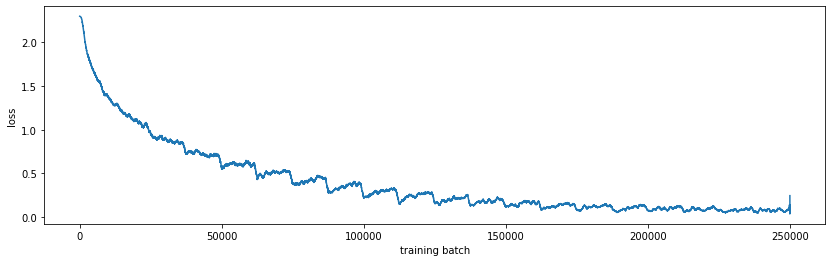

In [7]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+1000]) for i in range(len(losses))])

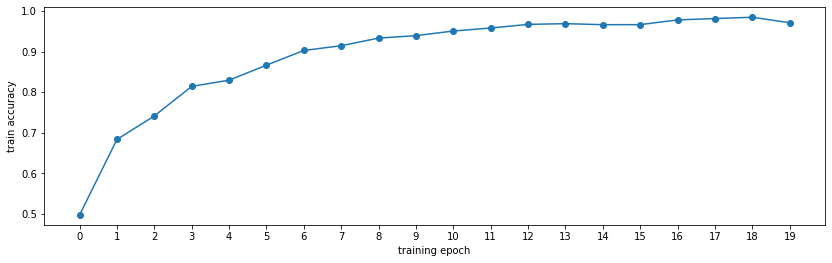

In [8]:

plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('train accuracy')
plt.plot(accuracies, marker='o')

In [9]:
# classes = ('plane', 'car',  'bird',  'cat',  'deer',
#            'dog',   'frog', 'horse', 'ship', 'truck')

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[792  15  57  17  20   9  10  16  42  22]
 [ 15 867   8  10   4   8   9   5  22  52]
 [ 53   4 702  43  57  67  38  23  10   3]
 [ 13   7  71 524  72 199  56  34  12  12]
 [ 12   2  68  41 760  43  16  49   7   2]
 [ 10   0  53 106  45 705  30  47   2   2]
 [  6   2  59  66  49  22 778  11   1   6]
 [ 12   2  46  39  48  85   3 761   0   4]
 [ 86  16  19  15  11  15   9  11 793  25]
 [ 44  69  12  15   5   9   9  29  24 784]]
F1 score: 0.746600
Accuracy score: 0.746600


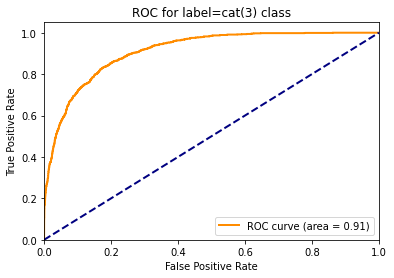

In [10]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 3
actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label=cat(%d) class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [11]:
total = 0
print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t\t', total)

Trainable parameters:
conv1.weight 	 1728
conv1.bias 	 64
conv2.weight 	 73728
conv2.bias 	 128
conv3.weight 	 294912
conv3.bias 	 256
fc1.weight 	 131072
fc1.bias 	 128
fc2.weight 	 32768
fc2.bias 	 256
fc3.weight 	 2560
fc3.bias 	 10

Total 		 537610
